In [1]:
%load_ext zipline

In [72]:
import pandas as pd
data = pd.read_csv("test1.csv")
print(data.iloc[20][1])
data.head()

151.36531000000002


,date,adj_close
0,2017-04-24,146.68918
1,2017-04-25,146.68228
2,2017-04-26,146.67883
3,2017-04-27,146.68750
4,2017-04-28,146.71251


2017-08-07
2017-11-08


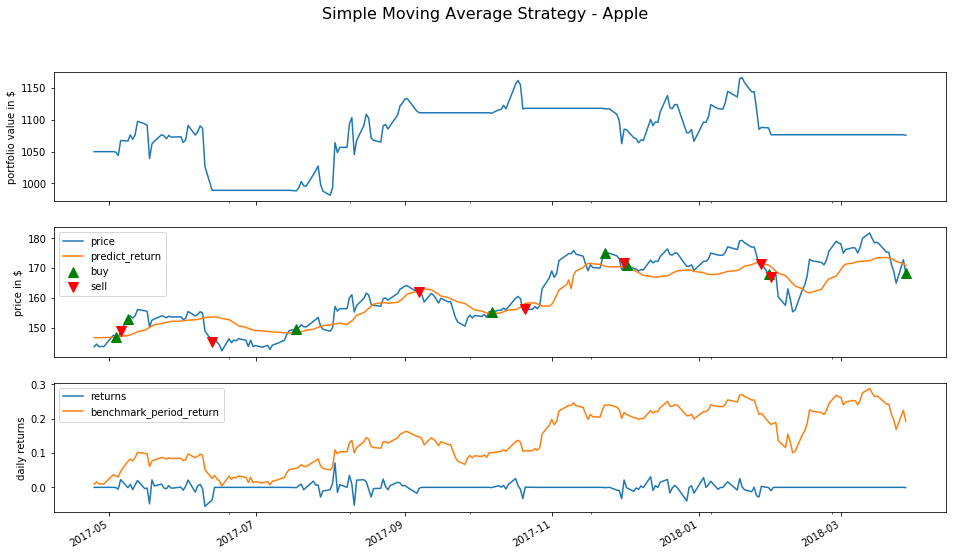

Final portfolio value (including cash): 1075.7$


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-04-24 20:00:00+00:00,NaN,0.000000,NaN,0.009629,NaN,NaN,0.0000,1050.00000,0.0,0.0,...,0.0,0.0,0,NaN,1050.00000,0.0,0.0,1,[],0.0
2017-04-25 20:00:00+00:00,0.000000,0.000000,0.000000,0.015957,0.037741,0.000000,0.0000,1050.00000,0.0,0.0,...,0.0,0.0,0,NaN,1050.00000,0.0,0.0,2,[],0.0
2017-04-26 20:00:00+00:00,0.000000,0.000000,0.000000,0.009700,0.132014,0.000000,0.0000,1050.00000,0.0,0.0,...,0.0,0.0,0,NaN,1050.00000,0.0,0.0,3,[],0.0
2017-04-27 20:00:00+00:00,0.000000,0.000000,0.000000,0.010685,0.109286,0.000000,0.0000,1050.00000,0.0,0.0,...,0.0,0.0,0,NaN,1050.00000,0.0,0.0,4,[],0.0
2017-04-28 20:00:00+00:00,0.000000,0.000000,0.000000,0.009700,0.098133,0.000000,0.0000,1050.00000,0.0,0.0,...,0.0,0.0,0,NaN,1050.00000,0.0,0.0,5,[],0.0
2017-05-01 20:00:00+00:00,0.000000,0.000000,0.000000,0.030433,0.149036,0.000000,0.0000,1050.00000,0.0,0.0,...,0.0,0.0,0,NaN,1050.00000,0.0,0.0,6,[],0.0
2017-05-02 20:00:00+00:00,0.000000,0.000000,0.000000,0.036831,0.136230,0.000000,0.0000,1050.00000,0.0,0.0,...,0.0,0.0,0,NaN,1050.00000,0.0,0.0,7,[],0.0
2017-05-03 20:00:00+00:00,0.003984,-0.000710,-0.032590,0.033671,0.134374,0.010228,-1471.3453,-421.34530,1470.6,1470.6,...,0.0,0.0,0,-5.612486,1050.00000,0.0,0.0,8,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-05-04 20:00:00+00:00,0.026522,-0.005757,-0.198086,0.029944,0.132273,0.071061,0.0000,-421.34530,1465.3,1465.3,...,0.0,0.0,0,-5.976361,-421.34530,1470.6,1470.6,9,[],0.0
2017-05-05 20:00:00+00:00,0.119088,0.016667,-0.090800,0.047020,0.141375,0.443231,1488.8452,1067.49990,0.0,0.0,...,0.0,0.0,0,16.526591,-421.34530,1465.3,1465.3,10,"[{'amount': -10, 'commission': None, 'dt': 201...",0.0


In [119]:
%%zipline --start 2017-4-24 --end 2018-3-27 --capital-base 1050.0 -o sma_strategy.pkl
from zipline.api import order_target, record, symbol,get_datetime,set_benchmark
from zipline.finance import commission
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pandas as pd

# parameters 
ma_periods = 20
selected_stock = 'AAPL'
n_stocks_to_buy = 10

def initialize(context):
    context.time = 0
    context.asset = symbol(selected_stock)
    set_benchmark(symbol('AAPL'))
    # 1. manually setting the commission
    context.set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

def handle_data(context, data):
    # 2. warm-up period
    context.time += 1
    #if context.time < ma_periods:
        #return
    # 3. access price history
    price_history = data.history(context.asset, fields="price", bar_count=ma_periods, frequency="1d")
    pred = pd.read_csv("test1.csv")
    pred["date"] = pd.to_datetime(pred["date"])
    
    # 4. calculate moving averages
    #ma = price_history.mean()
    tday=get_datetime().date()
    
    ma1 =pred[pred["date"]==tday]["adj_close"].values
    try:
        ma = ma1[0]
    except:
        print(tday)
        ma = price_history.mean()
    # 5. trading logic
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma):
        order_target(context.asset, n_stocks_to_buy)
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma):
        order_target(context.asset, 0)

    # save values for later inspection
    record(price=data.current(context.asset, 'price'),
           predict_return=ma)
    
# 6. analyze block
def analyze(context, perf):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])
    # portfolio value
    perf.portfolio_value.plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')
    
    # asset
    perf[['price', 'predict_return']].plot(ax=ax[1])
    ax[1].set_ylabel('price in $')
    
    # mark transactions
    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, perf.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, perf.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
    ax[1].legend()
    
    # daily returns
    perf.returns.plot(ax=ax[2])
    perf.benchmark_period_return.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')

    fig.suptitle('Simple Moving Average Strategy - Apple', fontsize=16)
    plt.legend()
    plt.show()
    
    print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))